In [1]:
%%capture
%cd ..

In [2]:
from src.model.esn import ESN
from src.model.lstm import LSTM
from src.trainer.esn_trainer import ESNTrainer
from src.trainer.lstm_trainer import LSTMTrainer
from src.dataset import SifimDataset
from src.trainer.model_selection import retraining
import torch
import matplotlib.pyplot as plt

In [3]:
batch_size=16
shuffle=True

tr_dataset = SifimDataset(start=0.0, end=0.6)
ts_dataset = SifimDataset(start=0.8, end=1, test=True, noise=0.005)

In [4]:
def format_result(result):
    return dict(mse=result[0], time=result[1], emissions=result[2], **result[3])

In [5]:
lstm_results = []


def store_lstm_accuracy(trainer):
    lstm_results.append(format_result(trainer.test()))

retraining(
    model_constructor=LSTM,
    trainer_constructor=lambda *args, **kwargs: LSTMTrainer(*args, callback=store_lstm_accuracy, **kwargs),
    tr_dataset=tr_dataset,
    ts_dataset=ts_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    hyperparams_path=f'hyperparams/LSTM_hyperparams.json',
    model_path=None,  #f'models/LSTM.torch',
    history_path='history/history.json',
)

2023-11-26 23:51:40,556 - root - INFO - LSTM results => training loss: 4.030249820258507e-06, test loss: 0.1808979301948052, tr_time: 115.94092011451721, tr_emissions: 0.0001207272140802062, ts_time: 0.677623987197876, ts_emissions: 0.0001221748582364667, scores: {'accuracy': 0.8191020698051948, 'precision': 0.9493901017518572, 'recall': 0.6996568813131313, 'f1_score': 0.8056022927242099}


LSTM(
  (lstm): LSTM(88, 200, batch_first=True)
  (ff1): Linear(in_features=200, out_features=500, bias=True)
  (ff2): Linear(in_features=500, out_features=88, bias=True)
)

In [6]:
esn_results = format_result(ESNTrainer(
    torch.load('models/ESN.torch'),
    torch.utils.data.DataLoader(tr_dataset, batch_size=batch_size, shuffle=shuffle),
    torch.utils.data.DataLoader(ts_dataset, batch_size=batch_size, shuffle=shuffle),
).test())

In [13]:
def plot(key):
    plt.figure(figsize=(12, 7))
    plt.title(key)
    plt.plot([r[key] for r in lstm_results], label='LSTM')
    plt.plot([esn_results[key] for _ in lstm_results], linestyle='--', label='ESN')
    plt.xlabel('epochs')
    plt.ylabel(key)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/development_{key}')
    plt.show()

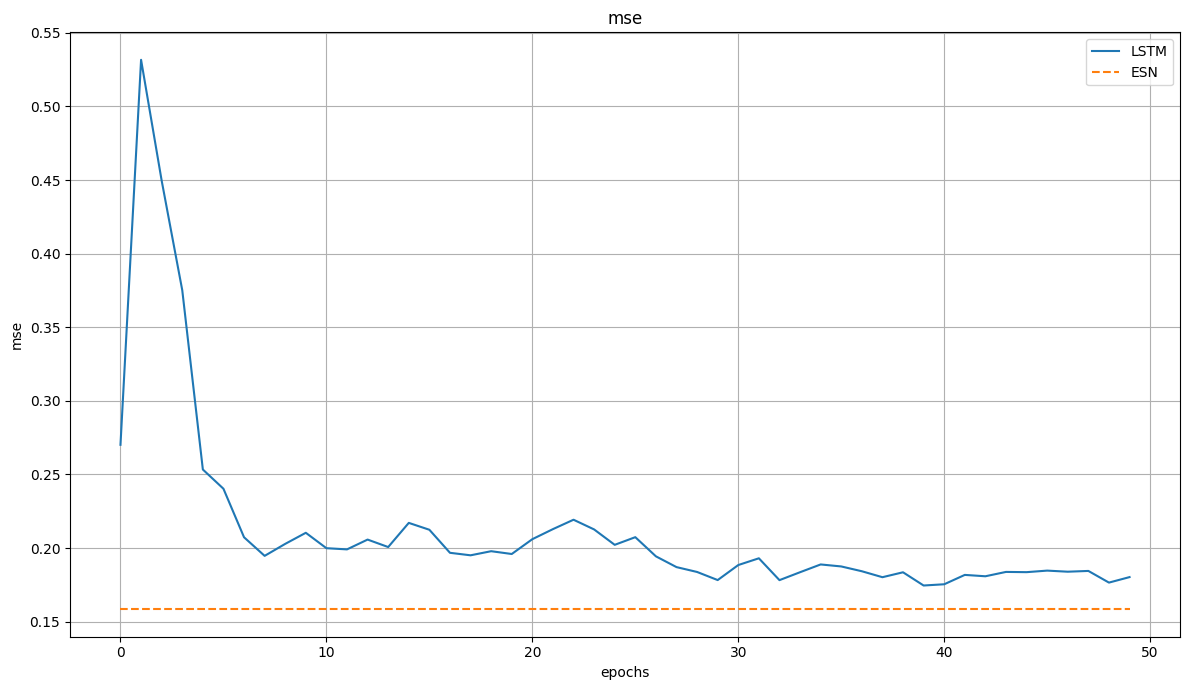

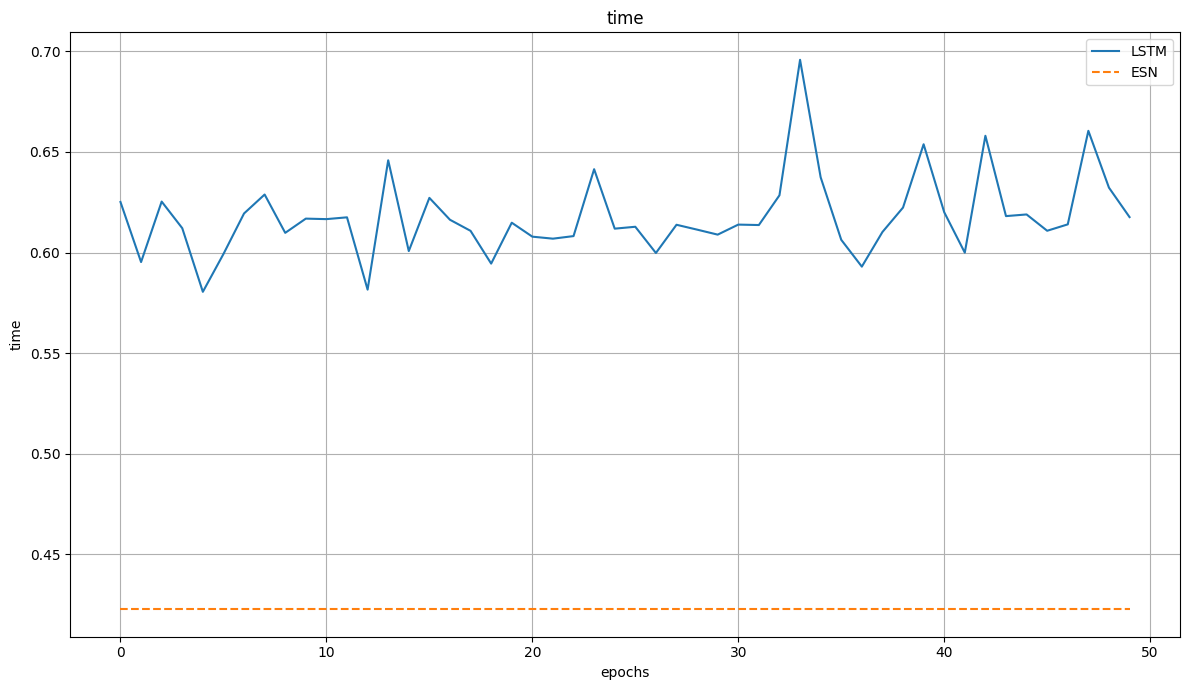

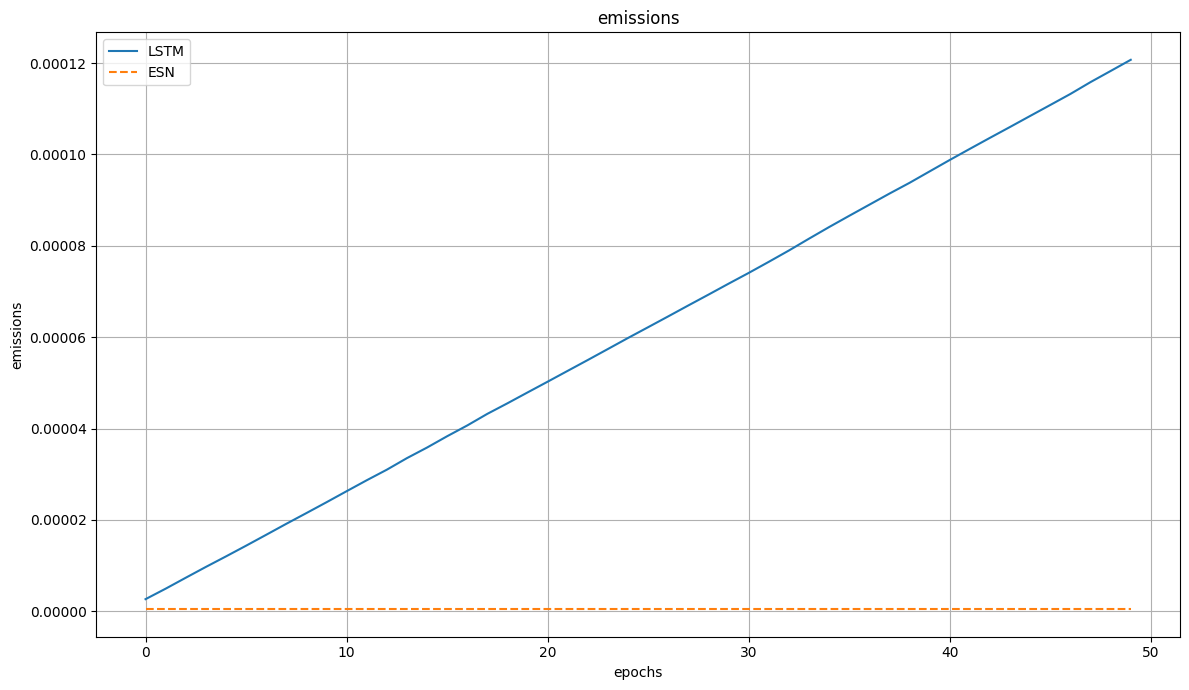

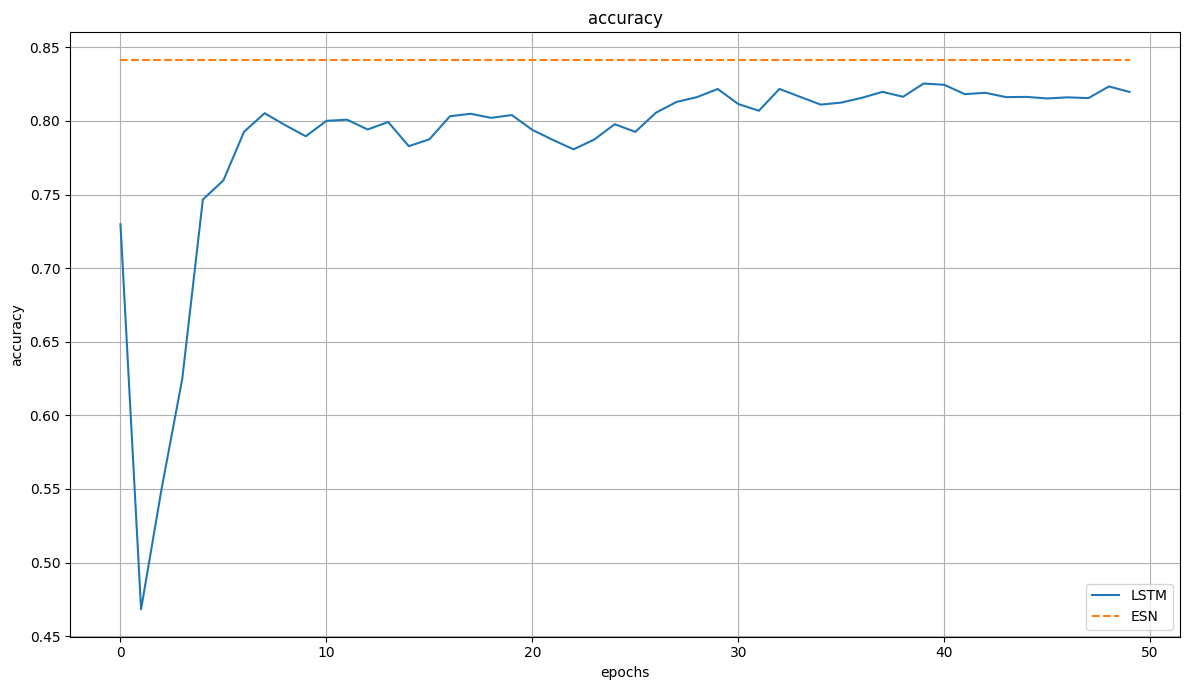

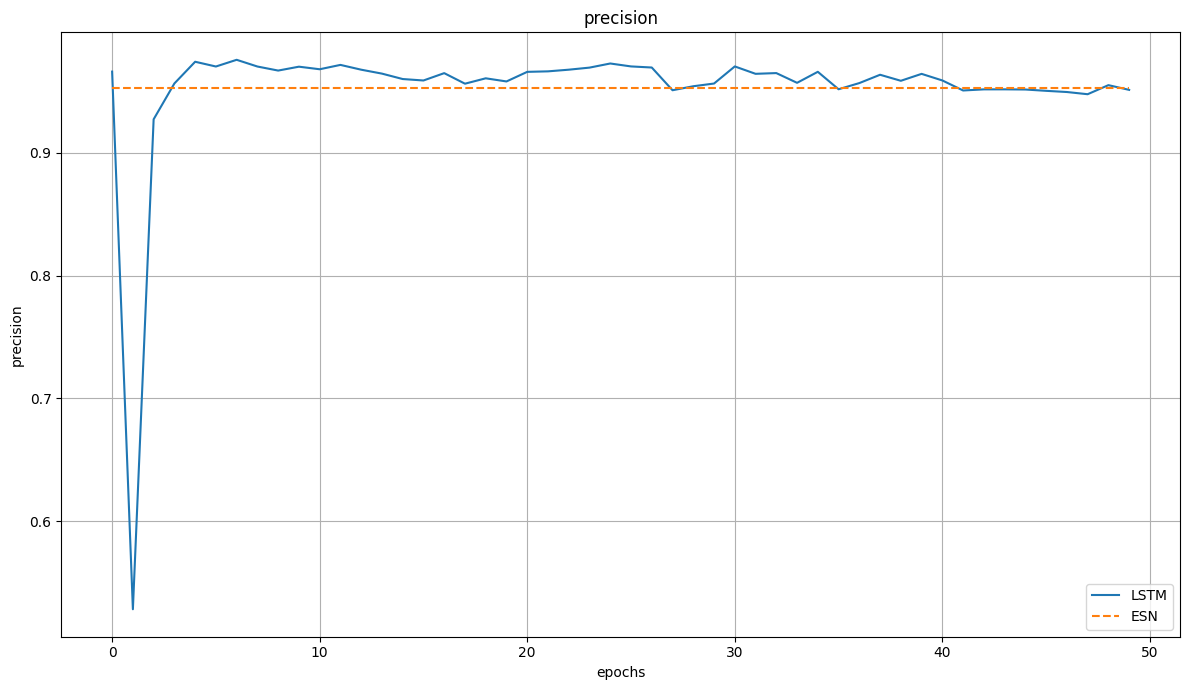

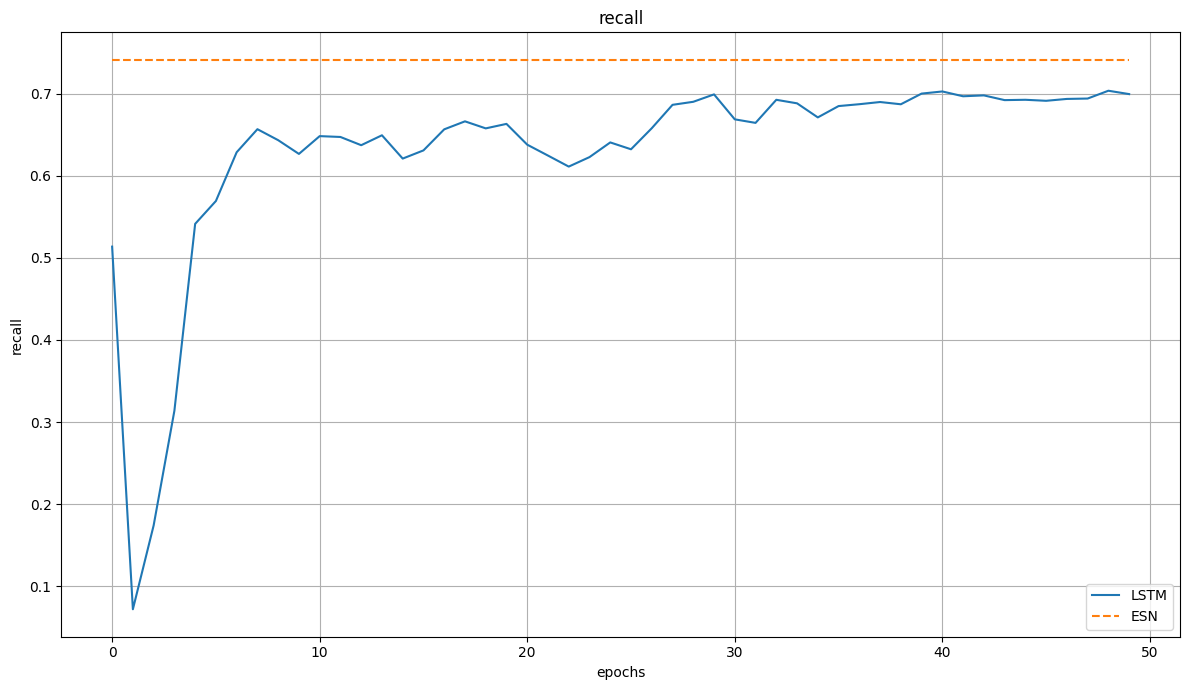

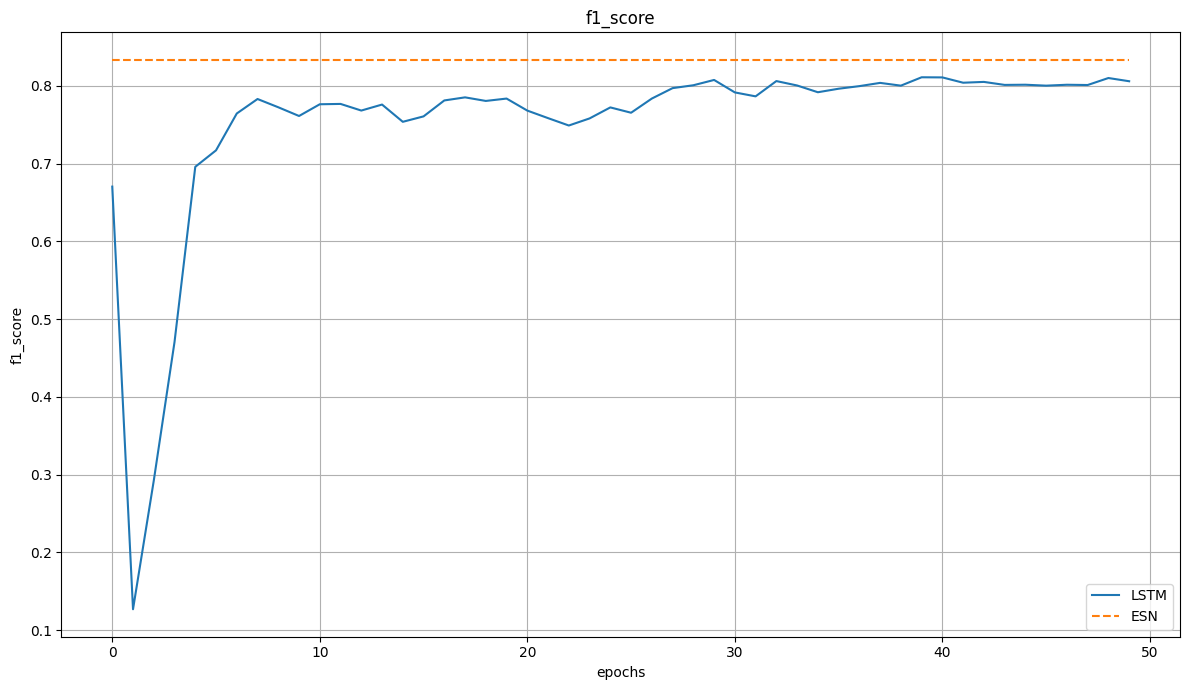

In [14]:
for k in esn_results.keys():
    plot(k)